To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
<a href="https://unsloth.ai/"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
<a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
<a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://docs.unsloth.ai/get-started/installing-+-updating).

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save)


### News

Unsloth now supports Text-to-Speech (TTS) models. Read our [guide here](https://docs.unsloth.ai/basics/text-to-speech-tts-fine-tuning).

Read our **[Qwen3 Guide](https://docs.unsloth.ai/basics/qwen3-how-to-run-and-fine-tune)** and check out our new **[Dynamic 2.0](https://docs.unsloth.ai/basics/unsloth-dynamic-2.0-ggufs)** quants which outperforms other quantization methods!

Visit our docs for all our [model uploads](https://docs.unsloth.ai/get-started/all-our-models) and [notebooks](https://docs.unsloth.ai/get-started/unsloth-notebooks).


### Installation

In [1]:
#!pip install unsloth

### Unsloth

In [1]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 4096 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",      # Llama-3.1 15 trillion tokens model 2x faster!
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",    # We also uploaded 4bit for 405b!
    "unsloth/Mistral-Nemo-Base-2407-bnb-4bit", # New Mistral 12b 2x faster!
    "unsloth/Mistral-Nemo-Instruct-2407-bnb-4bit",
    "unsloth/mistral-7b-v0.3-bnb-4bit",        # Mistral v3 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",           # Phi-3.5 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",            # Gemma 2x faster!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.6.2: Fast Llama patching. Transformers: 4.52.4.
   \\   /|    NVIDIA GeForce RTX 4090. Num GPUs = 2. Max memory: 23.51 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.9. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [2]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2025.6.2 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


<a name="Data"></a>
### Data Prep
We now use the Alpaca dataset from [yahma](https://huggingface.co/datasets/yahma/alpaca-cleaned), which is a filtered version of 52K of the original [Alpaca dataset](https://crfm.stanford.edu/2023/03/13/alpaca.html). You can replace this code section with your own data prep.

**[NOTE]** To train only on completions (ignoring the user's input) read TRL's docs [here](https://huggingface.co/docs/trl/sft_trainer#train-on-completions-only).

**[NOTE]** Remember to add the **EOS_TOKEN** to the tokenized output!! Otherwise you'll get infinite generations!

If you want to use the `llama-3` template for ShareGPT datasets, try our conversational [notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Alpaca.ipynb)

For text completions like novel writing, try this [notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Mistral_(7B)-Text_Completion.ipynb).

In [3]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    instruction = "Classify the following medical transcription into the correct medical specialty."
    inputs = examples["transcription"]
    outputs = examples["medical_specialty"]

    texts = [
        alpaca_prompt.format(instruction, input_, output_) + EOS_TOKEN
        for input_, output_ in zip(inputs, outputs)
    ]
    return {"text": texts}

from datasets import load_dataset, DatasetDict
# Full data 로드
full_dataset = load_dataset("hpe-ai/medical-cases-classification-tutorial", split="train+validation+test")
# shuffle
full_dataset = full_dataset.shuffle(seed=42)
# prompt formatting
full_dataset = full_dataset.map(formatting_prompts_func, batched=True)

# train:test = 7.5:2.5 (train:val:test=7.5:1.25:1.25)
train_testvalid = full_dataset.train_test_split(test_size=0.25, seed=42)
test_valid_split = train_testvalid['test'].train_test_split(test_size=0.5, seed=42)

# 최종 split 구성
dataset = DatasetDict({
    'train': train_testvalid['train'],
    'validation': test_valid_split['train'],
    'test': test_valid_split['test']
})
train_dataset = dataset["train"]
eval_dataset = dataset["validation"]
test_dataset = dataset["test"]

Repo card metadata block was not found. Setting CardData to empty.


<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

In [4]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    eval_dataset = eval_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 8,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        # num_train_epochs = 1, # Set this for 1 full training run.
        max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
)

Unsloth: Tokenizing ["text"]:   0%|          | 0/1848 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"]:   0%|          | 0/308 [00:00<?, ? examples/s]

In [5]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA GeForce RTX 4090. Max memory = 23.51 GB.
7.625 GB of memory reserved.


In [6]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,848 | Num Epochs = 3 | Total steps = 60
O^O/ \_/ \    Batch size per device = 16 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (16 x 4 x 1) = 64
 "-____-"     Trainable parameters = 41,943,040/8,000,000,000 (0.52% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,2.050200
2,2.048200
3,2.008500
4,1.958900
5,2.007100
6,1.925000
7,1.869900
8,1.853200
9,1.784500
10,1.747600


In [7]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

1440.0001 seconds used for training.
24.0 minutes used for training.
Peak reserved memory = 12.561 GB.
Peak reserved memory for training = 4.936 GB.
Peak reserved memory % of max memory = 53.428 %.
Peak reserved memory for training % of max memory = 20.995 %.


# Test Evaluation

100%|█████████████████████████████████████████| 308/308 [01:01<00:00,  5.00it/s]


✅ Accuracy: 0.7792207792207793

📄 Classification Report:
                          precision    recall  f1-score   support

cardiovascular/pulmonary       0.86      0.95      0.90        97
      ent/otolaryngology       0.78      0.58      0.67        12
        gastroenterology       0.78      0.78      0.78        23
     hematology/oncology       0.71      0.63      0.67        19
              nephrology       1.00      0.62      0.77         8
               neurology       0.58      0.64      0.61        33
            neurosurgery       0.45      0.50      0.48        10
   obstetrics/gynecology       0.85      0.81      0.83        21
           ophthalmology       1.00      0.86      0.92         7
              orthopedic       0.83      0.86      0.84        56
     pediatrics/neonatal       0.80      0.44      0.57         9
   psychiatry/psychology       0.83      0.45      0.59        11
               radiology       0.00      0.00      0.00         2

               mi

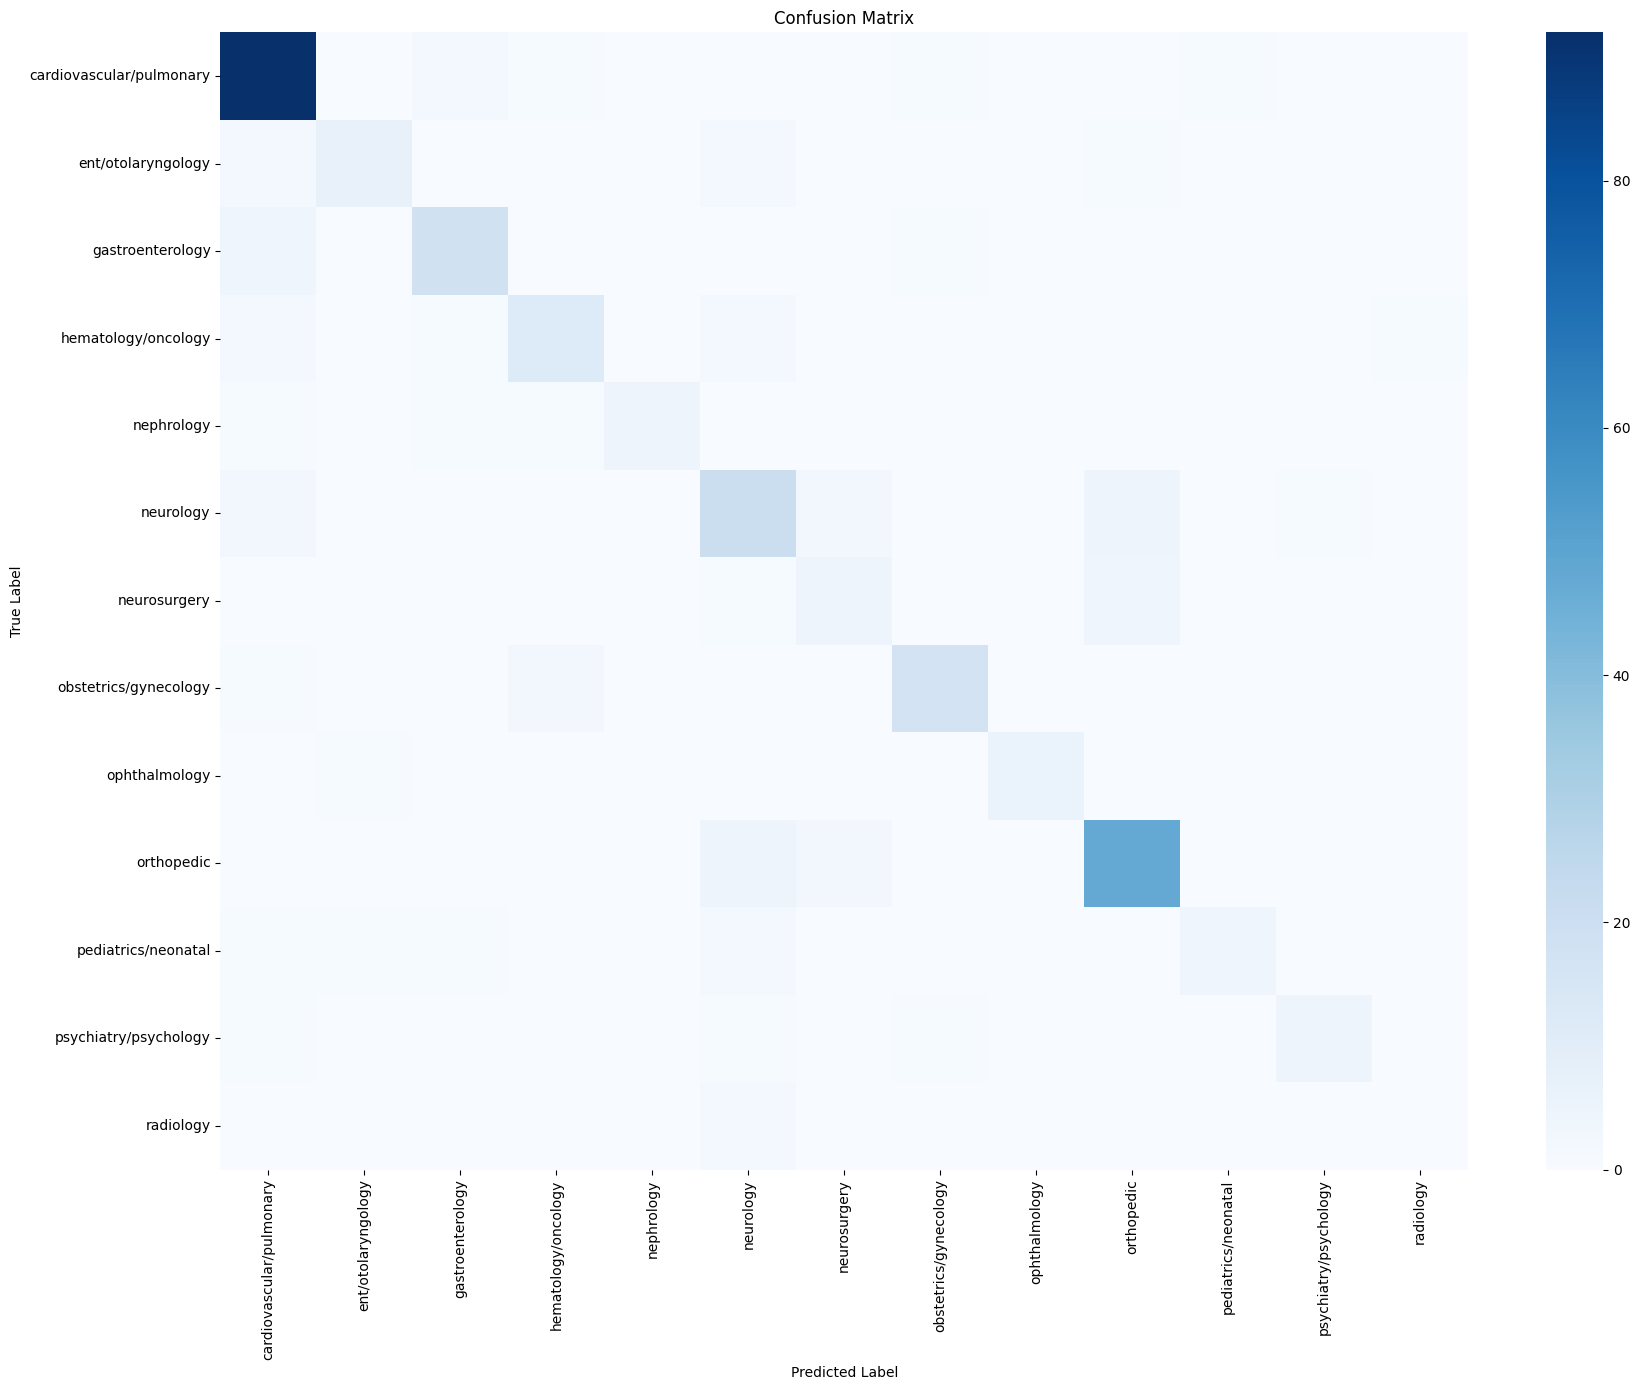


--- examples ---

Example 1:
Transcription:
INDICATIONS FOR PROCEDURE:, This is a 61-year-old, white male with onset of chest pain at 04: 30 this morning, with history of on and off chest discomfort over the past several days. CPK is already over 1000. There is ST elevation in leads II and aVF, as well as a Q wave. The chest pain is now gone, mild residual shortness of breath, no orthopnea. Cardiac monitor shows resolution of ST elevation lead III.,DESCRIPTION OF PROCEDURE:, Following sterile prep and drape of the right groin, installation of 1% Xylocaine anesthesia, the right common femoral artery was percutaneously entered and 6-French sheath inserted. ACT approximately 165 seconds on heparin. Borderline hypotension 250 mL fluid bolus given and nitroglycerin patch removed. Selective left and right coronary injections performed using Judkins coronary catheters with a 6-French pigtail catheter used to obtain left ventricular pressures and left ventriculography. Left pullback pressure.

In [8]:
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import numpy as np

# example
examples_to_show = 3  
example_results = []

# Alpaca prompt 템플릿
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

instruction = "Classify the following medical transcription into the correct medical specialty."

# 라벨 전처리 함수
def normalize_label(label):
    return label.lower().replace("-", "/").replace(" / ", "/").strip()

# 입력 길이 제한용 토큰 수
MAX_INPUT_TOKENS = 4096

labels, preds = [], []

# 라벨 집합 확보 (정규화된 기준으로)
all_classes = sorted(list({normalize_label(x["medical_specialty"]) for x in test_dataset}))

for example in tqdm(test_dataset):
    transcription = example["transcription"]
    true_label = normalize_label(example["medical_specialty"])
    labels.append(true_label)

    prompt = alpaca_prompt.format(instruction, transcription, "")

    # 토크나이징 + 길이 제한
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=MAX_INPUT_TOKENS).to("cuda")

    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=32, use_cache=True)
    output_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # "### Response:" 이후 예측값만 추출
    response = output_text.split("### Response:")[-1].strip().split("\n")[0]
    pred = normalize_label(response)
    preds.append(pred)

    # 평가 결과 예시 저장
    if len(example_results) < examples_to_show:
        example_results.append({
            "transcription": transcription,
            "true_label": true_label,
            "predicted_label": pred,
            "model_response": response,
        })

# 정확도 및 리포트 출력
print("✅ Accuracy:", accuracy_score(labels, preds))
print("\n📄 Classification Report:")
print(classification_report(labels, preds, labels=all_classes))

# Confusion matrix
cm = confusion_matrix(labels, preds, labels=all_classes)

plt.figure(figsize=(18, 14))
sns.heatmap(cm, xticklabels=all_classes, yticklabels=all_classes, annot=False, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 예시 결과 3개 출력
print("\n--- examples ---")
for i, r in enumerate(example_results, 1):
    print(f"\nExample {i}:")
    print(f"Transcription:\n{r['transcription']}")
    print(f"True Label: {r['true_label']}")
    print(f"Predicted Label: {r['predicted_label']}")
    print(f"Model Response: {r['model_response']}")

<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [9]:
model.save_pretrained("lora_model_75")  # Local saving
tokenizer.save_pretrained("lora_model_75")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

('lora_model_75/tokenizer_config.json',
 'lora_model_75/special_tokens_map.json',
 'lora_model_75/chat_template.jinja',
 'lora_model_75/tokenizer.json')

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [10]:
if False:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "lora_model_8_2", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference

# alpaca_prompt = You MUST copy from above!

inputs = tokenizer(
[
    alpaca_prompt.format(
        "Classify the following medical transcription into the correct medical specialty.", # instruction
        "PREOPERATIVE DIAGNOSES:,1. Right axillary adenopathy.,2. Thrombocytopenia.,3. Hepatosplenomegaly.,POSTOPERATIVE DIAGNOSES:,1. Right axillary adenopathy.,2. Thrombocytopenia.,3. Hepatosplenomegaly.,PROCEDURE PERFORMED: ,Right axillary lymph node biopsy.,ANESTHESIA: , Local with sedation.,COMPLICATIONS: , None.,DISPOSITION: , The patient tolerated the procedure well and was transferred to the recovery room in stable condition.,BRIEF HISTORY: ,The patient is a 37-year-old male who presented to ABCD General Hospital secondary to hiccups and was ultimately found to have a right axillary mass to be severely thrombocytopenic with a platelet count of 2000 as well as having hepatosplenomegaly. The working diagnosis is lymphoma, however, the Hematology and Oncology Departments were requesting a lymph node biopsy in order to confirm the diagnosis as well as prognosis. Thus, the patient was scheduled for a lymph node biopsy with platelets running secondary to thrombocytopenia at the time of surgery.,INTRAOPERATIVE FINDINGS: , The patient was found to have a large right axillary lymphadenopathy, one of the lymph node was sent down as a fresh specimen.,PROCEDURE: ,After informed written consent, risks and benefits of this procedure were explained to the patient. The patient was brought to the operating suite, prepped and draped in a normal sterile fashion. Multiple lymph nodes were palpated in the right axilla, however, the most inferior node was to be removed. First, the skin was anesthetized with 1% lidocaine solution. Next, using a #15 blade scalpel, an incision was made approximately 4 cm in length transversally in the inferior axilla. Next, using electro Bovie cautery, maintaining hemostasis, dissection was carried down to the lymph node. The lymph node was then completely excised using electro Bovie cautery as well as hemostats to maintain hemostasis and then lymph node was sent to specimen fresh to the lab. Several hemostats were used, suture ligated with #3-0 Vicryl suture and hemostasis was maintained. Next the deep dermal layers were approximated with #3-0 Vicryl suture. After the wound has been copiously irrigated, the skin was closed with running subcuticular #4-0 undyed Vicryl suture and the pathology is pending. The patient did tolerated the procedure well. Steri-Strips and sterile dressings were applied and the patient was transferred to the Recovery in stable condition.", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Classify the following medical transcription into the correct medical specialty.

### Input:
PREOPERATIVE DIAGNOSES:,1. Right axillary adenopathy.,2. Thrombocytopenia.,3. Hepatosplenomegaly.,POSTOPERATIVE DIAGNOSES:,1. Right axillary adenopathy.,2. Thrombocytopenia.,3. Hepatosplenomegaly.,PROCEDURE PERFORMED:,Right axillary lymph node biopsy.,ANESTHESIA:, Local with sedation.,COMPLICATIONS:, None.,DISPOSITION:, The patient tolerated the procedure well and was transferred to the recovery room in stable condition.,BRIEF HISTORY:,The patient is a 37-year-old male who presented to ABCD General Hospital secondary to hiccups and was ultimately found to have a right axillary mass to be severely thrombocytopenic with a platelet count of 2000 as well as having hepatosplenomegaly. The working diagnosis is 

You can also use Hugging Face's `AutoModelForPeftCausalLM`. Only use this if you do not have `unsloth` installed. It can be hopelessly slow, since `4bit` model downloading is not supported, and Unsloth's **inference is 2x faster**.

In [21]:
if False:
    # I highly do NOT suggest - use Unsloth if possible
    from peft import AutoPeftModelForCausalLM
    from transformers import AutoTokenizer
    model = AutoPeftModelForCausalLM.from_pretrained(
        "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = load_in_4bit,
    )
    tokenizer = AutoTokenizer.from_pretrained("lora_model")

### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16 or `merged_4bit` for int4. We also allow `lora` adapters as a fallback. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
# Merge to 16bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_16bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_16bit", token = "")

# Merge to 4bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_4bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_4bit", token = "")

# Just LoRA adapters
if False:
    model.save_pretrained("model")
    tokenizer.save_pretrained("model")
if False:
    model.push_to_hub("hf/model", token = "")
    tokenizer.push_to_hub("hf/model", token = "")


### GGUF / llama.cpp Conversion
To save to `GGUF` / `llama.cpp`, we support it natively now! We clone `llama.cpp` and we default save it to `q8_0`. We allow all methods like `q4_k_m`. Use `save_pretrained_gguf` for local saving and `push_to_hub_gguf` for uploading to HF.

Some supported quant methods (full list on our [Wiki page](https://github.com/unslothai/unsloth/wiki#gguf-quantization-options)):
* `q8_0` - Fast conversion. High resource use, but generally acceptable.
* `q4_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q4_K.
* `q5_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q5_K.

[**NEW**] To finetune and auto export to Ollama, try our [Ollama notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Ollama.ipynb)

In [ ]:
# Save to 8bit Q8_0
if False: model.save_pretrained_gguf("model", tokenizer,)
# Remember to go to https://huggingface.co/settings/tokens for a token!
# And change hf to your username!
if False: model.push_to_hub_gguf("hf/model", tokenizer, token = "")

# Save to 16bit GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "f16")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "f16", token = "")

# Save to q4_k_m GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q4_k_m", token = "")

# Save to multiple GGUF options - much faster if you want multiple!
if False:
    model.push_to_hub_gguf(
        "hf/model", # Change hf to your username!
        tokenizer,
        quantization_method = ["q4_k_m", "q8_0", "q5_k_m",],
        token = "",
    )

Now, use the `model-unsloth.gguf` file or `model-unsloth-Q4_K_M.gguf` file in llama.cpp or a UI based system like Jan or Open WebUI. You can install Jan [here](https://github.com/janhq/jan) and Open WebUI [here](https://github.com/open-webui/open-webui)

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/unsloth) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Train your own reasoning model - Llama GRPO notebook [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.1_(8B)-GRPO.ipynb)
2. Saving finetunes to Ollama. [Free notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Ollama.ipynb)
3. Llama 3.2 Vision finetuning - Radiography use case. [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.2_(11B)-Vision.ipynb)
6. See notebooks for DPO, ORPO, Continued pretraining, conversational finetuning and more on our [documentation](https://docs.unsloth.ai/get-started/unsloth-notebooks)!

<div class="align-center">
  <a href="https://unsloth.ai"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a>

  Join Discord if you need help + ⭐️ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐️
</div>
